In [1]:
import geopandas as gpd
import os
import zipfile as zf
import geopandas
from shapely.geometry import shape
import gzip 
import urllib.request
import xarray as xr
import io
import shapefile
import pandas as pd
import json

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [138]:
df = pd.read_pickle("GDP_temperature_anomalies_1947_USA.pkl")

In [91]:
df

,time,timeMin,timeMax,gdp
0,1947-01-15,-6.66,4.33,2033.061000
1,1947-02-15,-3.48,3.51,2031.253667
2,1947-03-15,-3.64,4.59,2029.446333
3,1947-04-15,-1.90,1.61,2027.639000
4,1947-05-15,-2.55,2.46,2026.243333
...,...,...,...,...
887,2020-12-15,-0.27,5.58,18989.854000
888,2021-01-15,0.48,7.10,19087.568000
889,2021-02-15,-4.14,1.27,NaN
890,2021-03-15,-1.28,5.49,NaN


In [139]:
df = df.reset_index()
df['time'] = pd.to_datetime(df['time'])
df = df.set_index(df['time'])
df = df.sort_index()
df =  df.drop(["time","index","gdp"], axis =1)

In [93]:
df

,timeMin,timeMax
time,,
1947-01-15,-6.66,4.33
1947-02-15,-3.48,3.51
1947-03-15,-3.64,4.59
1947-04-15,-1.90,1.61
1947-05-15,-2.55,2.46
...,...,...
2020-12-15,-0.27,5.58
2021-01-15,0.48,7.10
2021-02-15,-4.14,1.27


In [97]:
892*0.75

669.0

In [73]:
df

,timeMin,timeMax
time,,
1980-01-15,0.662583,0.124825
1980-02-15,0.568332,0.467742
1980-03-15,0.680490,0.229313
1980-04-15,0.681433,0.214586
1980-05-15,0.672008,0.168303
...,...,...
2020-12-15,0.786993,0.392006
2021-01-15,0.857681,0.498597
2021-02-15,0.422243,0.089762


In [140]:
train,test = df[1:669], df[669:] 

In [99]:
train

,timeMin,timeMax
time,,
1947-02-15,-3.48,3.51
1947-03-15,-3.64,4.59
1947-04-15,-1.90,1.61
1947-05-15,-2.55,2.46
1947-06-15,-1.95,1.63
...,...,...
2002-05-15,-2.23,2.51
2002-06-15,-0.40,2.27
2002-07-15,-0.47,3.18


Scaling dataset

In [141]:
pd.options.mode.chained_assignment = None  # default='warn'
min_max_scaler = MinMaxScaler()
train[["timeMin", "timeMax"]] = min_max_scaler.fit_transform(train[["timeMin", "timeMax"]])

,timeMin,timeMax
time,,
1947-02-15,0.551935,0.294813
1947-03-15,0.535642,0.365725
1947-04-15,0.712831,0.170059
1947-05-15,0.646639,0.225870
1947-06-15,0.707739,0.171372
...,...,...
2002-05-15,0.679226,0.229153
2002-06-15,0.865580,0.213395
2002-07-15,0.858452,0.273145


In [142]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [143]:
n_past = 50
n_future = 1
n_features = 2

In [144]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [145]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#padded_shapes = ([618], ())#None.
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
lstm_36 (LSTM)                  [(None, 100), (None, 41200       input_13[0][0]                   
__________________________________________________________________________________________________
repeat_vector_12 (RepeatVector) (None, 1, 100)       0           lstm_36[0][0]                    
__________________________________________________________________________________________________
lstm_37 (LSTM)                  (None, 1, 100)       80400       repeat_vector_12[0][0]           
                                                                 lstm_36[0][1]        

In [146]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

618
173
618
173


In [147]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#padded_shapes = ([618], ()) #THIS IS TO GET RID OF :WARNING:tensorflow:10 out of the last 11 calls to <function train_step at 0x7f4825f6d400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different ecc
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
lstm_38 (LSTM)                  [(None, 50, 100), (N 41200       input_14[0][0]                   
__________________________________________________________________________________________________
lstm_39 (LSTM)                  [(None, 100), (None, 80400       lstm_38[0][0]                    
__________________________________________________________________________________________________
repeat_vector_13 (RepeatVector) (None, 1, 100)       0           lstm_39[0][0]                    
______________________________________________________________________________________

In [148]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

Epoch 1/25
20/20 [==============================] - 1s 72ms/step - loss: 0.0409 - val_loss: 2.1958
Epoch 2/25
20/20 [==============================] - 1s 31ms/step - loss: 0.0106 - val_loss: 2.2028
Epoch 3/25
20/20 [==============================] - 1s 31ms/step - loss: 0.0101 - val_loss: 2.2173
Epoch 4/25
20/20 [==============================] - 1s 29ms/step - loss: 0.0102 - val_loss: 2.2122
Epoch 5/25
20/20 [==============================] - 1s 32ms/step - loss: 0.0100 - val_loss: 2.2107
Epoch 6/25
20/20 [==============================] - 1s 31ms/step - loss: 0.0100 - val_loss: 2.2212
Epoch 7/25
20/20 [==============================] - 1s 30ms/step - loss: 0.0099 - val_loss: 2.2326
Epoch 8/25
20/20 [==============================] - 1s 28ms/step - loss: 0.0099 - val_loss: 2.2442
Epoch 9/25
20/20 [==============================] - 1s 30ms/step - loss: 0.0098 - val_loss: 2.2496
Epoch 10/25
20/20 [==============================] - 1s 29ms/step - loss: 0.0099 - val_loss: 2.2483
Epoch 11/

In [149]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

In [150]:
pred_e1d1

array([[[0.8355015 , 0.6648116 ]],

       [[0.9477779 , 0.7817507 ]],

       [[1.0371783 , 0.75764585]],

       [[0.98786074, 0.6408171 ]],

       [[0.8200121 , 0.6957581 ]],

       [[0.8604261 , 0.7013415 ]],

       [[1.0052499 , 0.5265374 ]],

       [[1.0956419 , 0.376539  ]],

       [[1.0666051 , 0.42176357]],

       [[1.170862  , 0.3982046 ]],

       [[1.1838615 , 0.40509588]],

       [[1.1609948 , 0.48682398]],

       [[1.173403  , 0.69004226]],

       [[1.196585  , 0.7426717 ]],

       [[1.2154604 , 0.6435689 ]],

       [[1.2023203 , 0.5369686 ]],

       [[1.1746914 , 0.5188199 ]],

       [[1.1236416 , 0.4477539 ]],

       [[1.0535525 , 0.34525567]],

       [[1.0286741 , 0.2800086 ]],

       [[0.96315473, 0.18538968]],

       [[0.8489044 , 0.17091216]],

       [[0.779765  , 0.18265818]],

       [[0.5181231 , 0.19646113]],

       [[0.4951788 , 0.2980085 ]],

       [[0.41092208, 0.44112843]],

       [[0.36586592, 0.40106034]],

       [[0.46903732, 0.40319

In [151]:
pred_e2d2

array([[[ 1.23366678e+00,  3.61730248e-01]],

       [[ 1.35394144e+00,  3.86104256e-01]],

       [[ 1.40298760e+00,  3.95772338e-01]],

       [[ 1.36293030e+00,  3.18844646e-01]],

       [[ 1.21712577e+00,  3.69279772e-01]],

       [[ 1.27185452e+00,  3.26658428e-01]],

       [[ 1.39020979e+00,  1.23317160e-01]],

       [[ 1.45209014e+00, -3.79379839e-02]],

       [[ 1.41543257e+00, -9.21185501e-03]],

       [[ 1.49037600e+00, -5.71528077e-02]],

       [[ 1.48324859e+00, -3.38583514e-02]],

       [[ 1.45958829e+00,  5.64977378e-02]],

       [[ 1.47146940e+00,  2.63390481e-01]],

       [[ 1.48770845e+00,  3.83741051e-01]],

       [[ 1.51926446e+00,  3.26225609e-01]],

       [[ 1.53423083e+00,  2.27670729e-01]],

       [[ 1.52728891e+00,  1.98475629e-01]],

       [[ 1.49085724e+00,  1.35727376e-01]],

       [[ 1.44000828e+00,  3.74887884e-02]],

       [[ 1.41468108e+00, -4.55020368e-02]],

       [[ 1.34498703e+00, -1.29397318e-01]],

       [[ 1.23377860e+00, -1.50253

Trying to rescale it back:

In [118]:
pred_e1d1

array([[[0.8273743 , 0.79370624]],

       [[1.1508656 , 0.9567325 ]],

       [[1.254901  , 0.97861695]],

       [[1.0909071 , 0.83264905]],

       [[0.8206133 , 0.84674746]],

       [[0.93801266, 0.85351646]],

       [[1.1290182 , 0.6161981 ]],

       [[1.2246875 , 0.42144448]],

       [[1.2059498 , 0.4942795 ]],

       [[1.3912245 , 0.4522264 ]],

       [[1.3902321 , 0.48341095]],

       [[1.3822825 , 0.59960073]],

       [[1.4832363 , 0.8824918 ]],

       [[1.494795  , 0.99587184]],

       [[1.4383651 , 0.8645759 ]],

       [[1.369577  , 0.701273  ]],

       [[1.3411762 , 0.6633656 ]],

       [[1.2458911 , 0.56537974]],

       [[1.1354998 , 0.41738775]],

       [[1.1302475 , 0.31868386]],

       [[1.0371    , 0.19750166]],

       [[0.912163  , 0.17166181]],

       [[0.8669664 , 0.17970067]],

       [[0.51172286, 0.17291912]],

       [[0.5738738 , 0.29582286]],

       [[0.44921288, 0.4674527 ]],

       [[0.38344252, 0.40487832]],

       [[0.57978934, 0.41932

Do all the rest for the model  check, plot ecc :(

we can also do it with gdp??! :3

In [165]:
df1 = pd.read_pickle("GDP_temperature_anomalies_1947_USA.pkl")

In [166]:
df1 = df1.reset_index()
df1['time'] = pd.to_datetime(df1['time'])
df1 = df1.set_index(df1['time'])
df1 = df1.sort_index()
df1 =  df1.drop(["time","index"], axis =1)

In [167]:
train1,test1 = df1[1:669], df1[669:] 

In [186]:
train1

,timeMin,timeMax,gdp
time,,,
1947-02-15,0.551935,0.294813,0.000677
1947-03-15,0.535642,0.365725,0.000520
1947-04-15,0.712831,0.170059,0.000363
1947-05-15,0.646639,0.225870,0.000242
1947-06-15,0.707739,0.171372,0.000121
...,...,...,...
2002-05-15,0.679226,0.229153,0.995323
2002-06-15,0.865580,0.213395,0.997055
2002-07-15,0.858452,0.273145,0.998788


In [187]:
pd.options.mode.chained_assignment = None  # default='warn'
min_max_scaler = MinMaxScaler()
train1[["timeMin", "timeMax","gdp"]] = min_max_scaler.fit_transform(train1[["timeMin", "timeMax","gdp"]])

In [188]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [189]:
n_past = 50
n_future = 1
n_features = 3

In [190]:
X_train, y_train = split_series(train1.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test1.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [191]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#padded_shapes = ([618], ())#None.
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
lstm_50 (LSTM)                  [(None, 100), (None, 41600       input_18[0][0]                   
__________________________________________________________________________________________________
repeat_vector_17 (RepeatVector) (None, 1, 100)       0           lstm_50[0][0]                    
__________________________________________________________________________________________________
lstm_51 (LSTM)                  (None, 1, 100)       80400       repeat_vector_17[0][0]           
                                                                 lstm_50[0][1]        

In [192]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#padded_shapes = ([618], ()) #THIS IS TO GET RID OF :WARNING:tensorflow:10 out of the last 11 calls to <function train_step at 0x7f4825f6d400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different ecc
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
lstm_52 (LSTM)                  [(None, 50, 100), (N 41600       input_19[0][0]                   
__________________________________________________________________________________________________
lstm_53 (LSTM)                  [(None, 100), (None, 80400       lstm_52[0][0]                    
__________________________________________________________________________________________________
repeat_vector_18 (RepeatVector) (None, 1, 100)       0           lstm_53[0][0]                    
______________________________________________________________________________________

In [193]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

Epoch 1/25
20/20 [==============================] - 1s 74ms/step - loss: 0.0469 - val_loss: nan
Epoch 2/25
20/20 [==============================] - 1s 36ms/step - loss: 0.0078 - val_loss: nan
Epoch 3/25
20/20 [==============================] - 1s 34ms/step - loss: 0.0069 - val_loss: nan
Epoch 4/25
20/20 [==============================] - 1s 34ms/step - loss: 0.0068 - val_loss: nan
Epoch 5/25
20/20 [==============================] - 1s 34ms/step - loss: 0.0067 - val_loss: nan
Epoch 6/25
20/20 [==============================] - 1s 33ms/step - loss: 0.0067 - val_loss: nan
Epoch 7/25
20/20 [==============================] - 1s 34ms/step - loss: 0.0066 - val_loss: nan
Epoch 8/25
20/20 [==============================] - 1s 33ms/step - loss: 0.0067 - val_loss: nan
Epoch 9/25
20/20 [==============================] - 1s 35ms/step - loss: 0.0066 - val_loss: nan
Epoch 10/25
20/20 [==============================] - 1s 34ms/step - loss: 0.0066 - val_loss: nan
Epoch 11/25
20/20 [====================

In [194]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

In [195]:
pred_e1d1

array([[[-0.15694465,  0.7049942 ,  0.19005384]],

       [[-0.15701984,  0.7049967 ,  0.19002122]],

       [[-0.15699758,  0.704996  ,  0.19003086]],

       [[-0.15697576,  0.7049953 ,  0.19004034]],

       [[-0.15694596,  0.7049942 ,  0.19005327]],

       [[-0.15698792,  0.70499563,  0.19003506]],

       [[-0.15700804,  0.70499635,  0.19002634]],

       [[-0.15700291,  0.70499617,  0.19002856]],

       [[-0.15698783,  0.70499563,  0.19003509]],

       [[-0.15700825,  0.70499635,  0.19002624]],

       [[-0.15699299,  0.7049958 ,  0.19003285]],

       [[-0.15698753,  0.70499563,  0.19003522]],

       [[-0.15699293,  0.7049958 ,  0.19003288]],

       [[-0.1569861 ,  0.70499563,  0.19003585]],

       [[-0.1569858 ,  0.7049956 ,  0.19003598]],

       [[-0.15698574,  0.7049956 ,  0.190036  ]],

       [[-0.15698595,  0.7049956 ,  0.19003591]],

       [[-0.15698119,  0.7049954 ,  0.19003798]],

       [[-0.15698414,  0.7049955 ,  0.1900367 ]],

       [[-0.15699531,  0.704995

In [196]:
pred_e2d2

array([[[0.62355673, 0.49294603, 1.9456784 ]],

       [[0.62399143, 0.4922947 , 1.9457861 ]],

       [[0.62394273, 0.49236792, 1.9457744 ]],

       [[0.6240395 , 0.49222296, 1.9457983 ]],

       [[0.6233113 , 0.4933137 , 1.9456173 ]],

       [[0.62391615, 0.49240768, 1.9457675 ]],

       [[0.6245752 , 0.49141937, 1.9459306 ]],

       [[0.6246029 , 0.49137807, 1.9459373 ]],

       [[0.6242205 , 0.49195144, 1.9458427 ]],

       [[0.62451804, 0.4915053 , 1.9459163 ]],

       [[0.6243991 , 0.49168342, 1.9458872 ]],

       [[0.6242394 , 0.49192327, 1.9458474 ]],

       [[0.6239141 , 0.49241078, 1.945767  ]],

       [[0.62393904, 0.49237344, 1.9457731 ]],

       [[0.6242616 , 0.49188995, 1.9458531 ]],

       [[0.6243849 , 0.49170512, 1.9458834 ]],

       [[0.6242896 , 0.49184787, 1.9458598 ]],

       [[0.62437546, 0.49171925, 1.9458812 ]],

       [[0.6245012 , 0.49153066, 1.945912  ]],

       [[0.6245753 , 0.49141932, 1.9459305 ]],

       [[0.62465674, 0.49129733, 1.94595

ANOTHER MODEL: https://github.com/imkhoa99/Time-Series-Analysis-and-Weather-Forecast-/blob/master/Time_Series_Project.ipynb

In [261]:
df2 = pd.read_pickle("GDP_temperature_anomalies_1947_USA.pkl")

In [262]:
df2 = df2.reset_index()
df2['time'] = pd.to_datetime(df2['time'])
df2 = df2.set_index(df2['time'])
df2 = df2.sort_index()
df2 =  df2.drop(["time","index","gdp"], axis =1)

In [263]:
df2

,timeMin,timeMax
time,,
1947-01-15,-6.66,4.33
1947-02-15,-3.48,3.51
1947-03-15,-3.64,4.59
1947-04-15,-1.90,1.61
1947-05-15,-2.55,2.46
...,...,...
2020-12-15,-0.27,5.58
2021-01-15,0.48,7.10
2021-02-15,-4.14,1.27


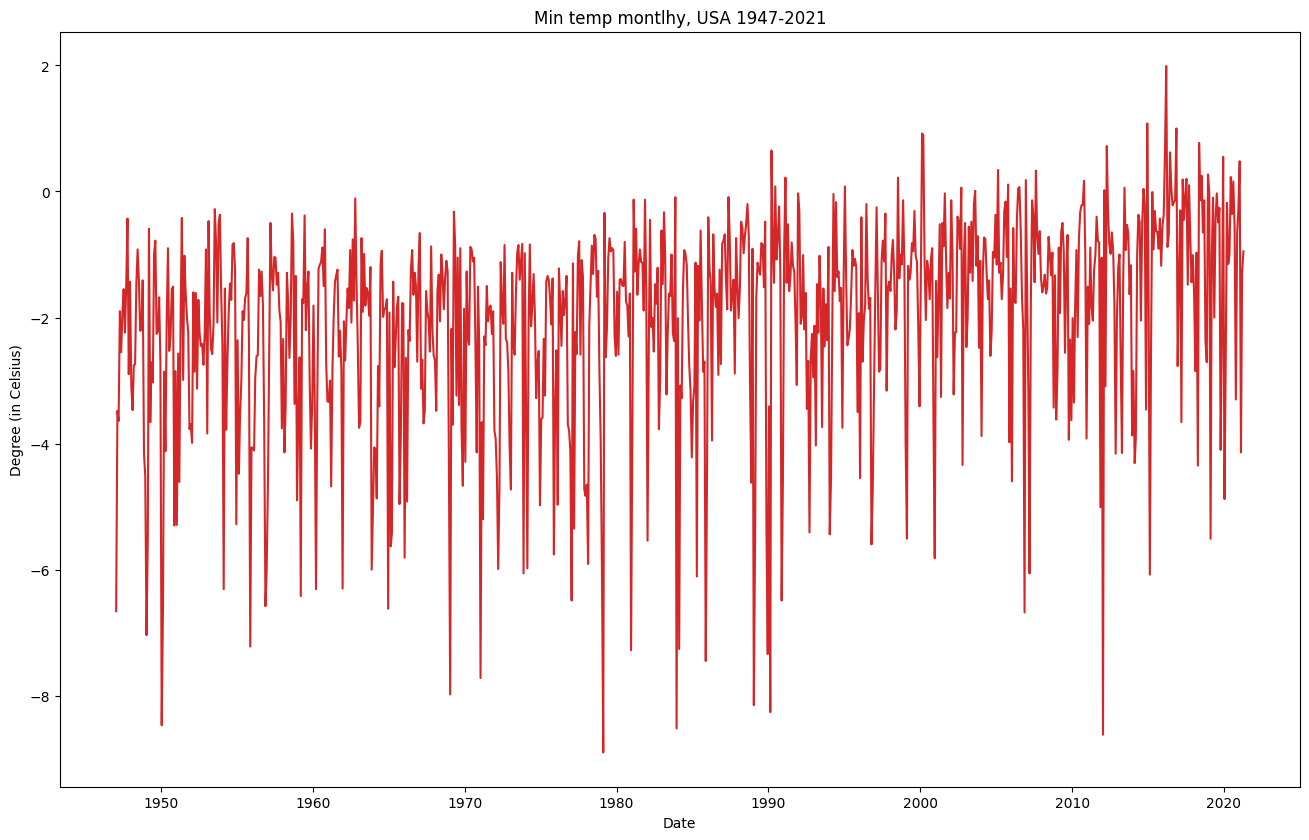

In [264]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(df2.index, df2.timeMin, color='tab:red')
plt.gca().set(title="Min temp montlhy, USA 1947-2021", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

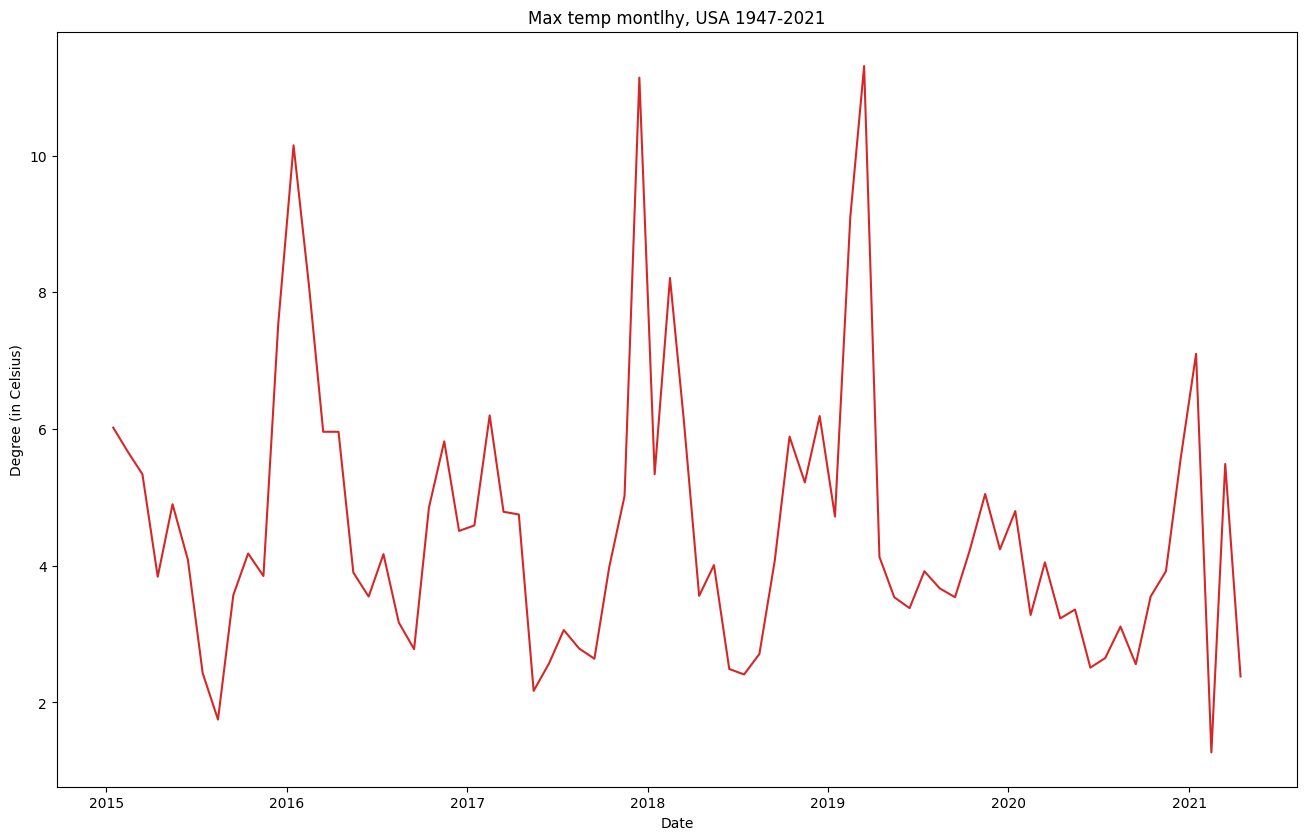

In [241]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(df3.index, df3.timeMax, color='tab:red')
plt.gca().set(title="Max temp montlhy, USA 1947-2021", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

<AxesSubplot:xlabel='time'>

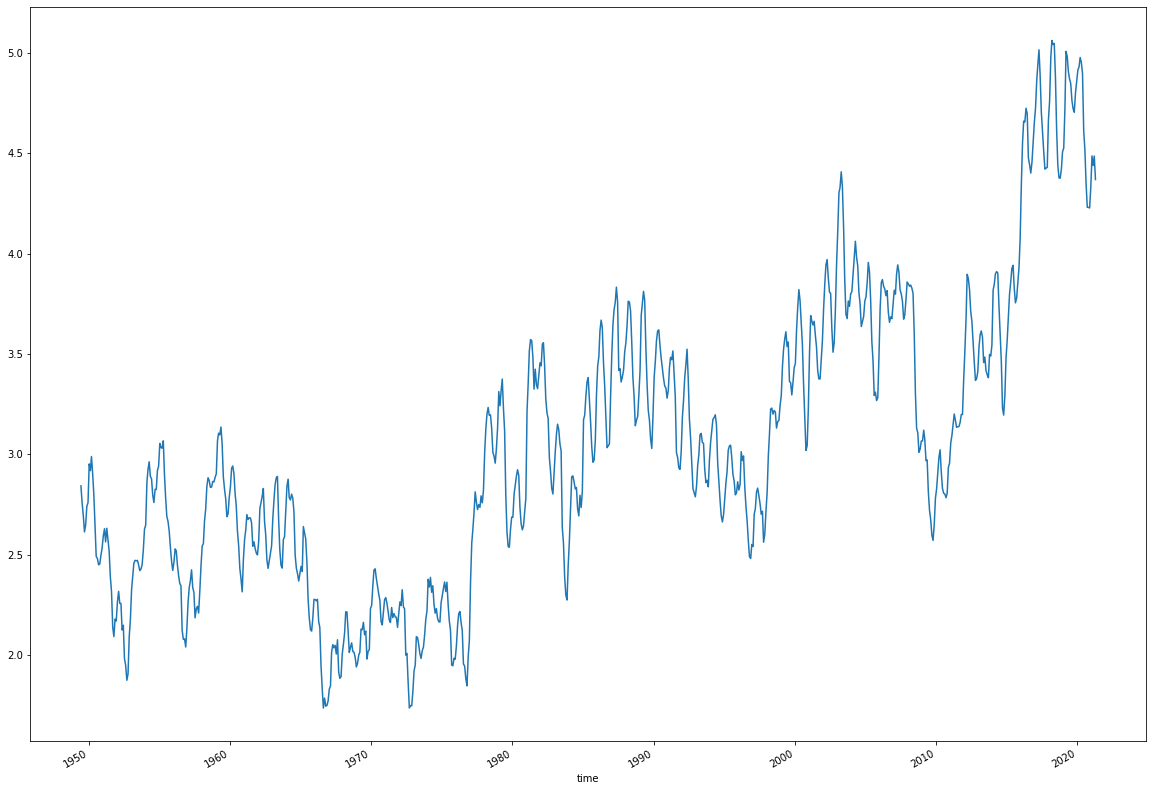

In [212]:

# Apply the Moving Average function by a subset of size 30 months to timeMax.
temp_df_mean = df2.timeMax.rolling(window=30).mean()
temp_df_mean.plot(figsize=(20,15))

<AxesSubplot:xlabel='time'>

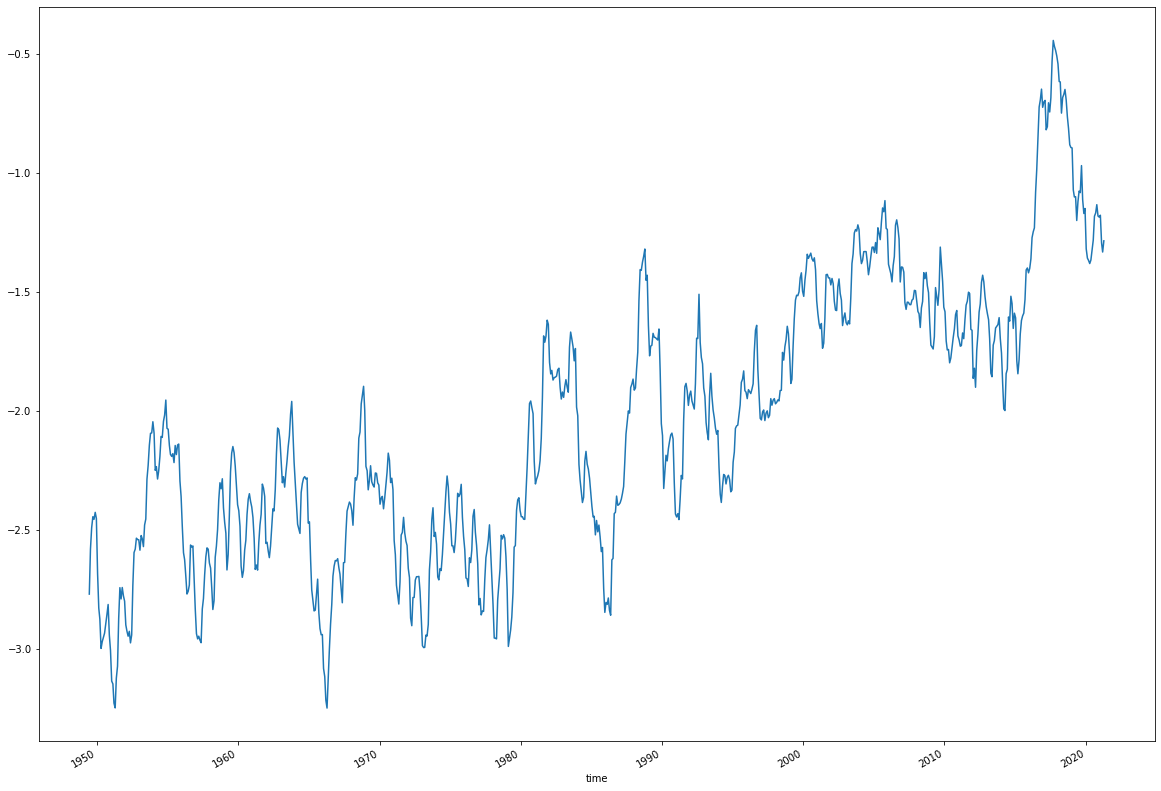

In [213]:

# Apply the Moving Average function by a subset of size 30 months to timeMin.
temp_df_mean = df2.timeMin.rolling(window=30).mean()
temp_df_mean.plot(figsize=(20,15))

is there a trend????

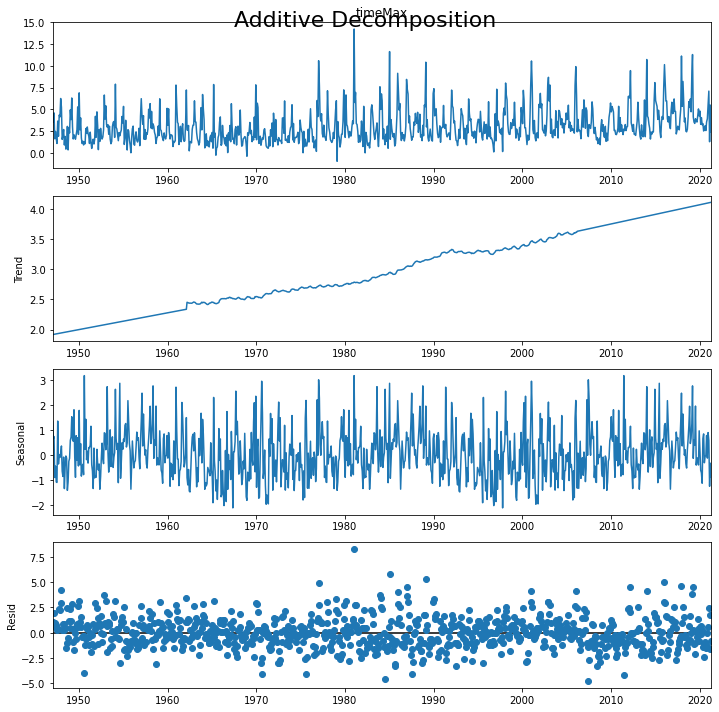

In [265]:
#FOR time MAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df2.timeMax, model='additive', extrapolate_trend='freq', freq=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

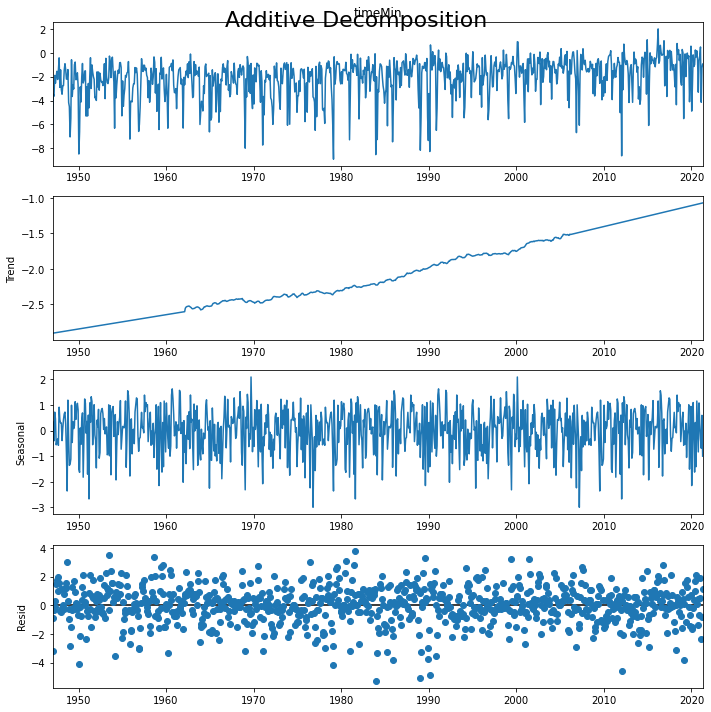

In [266]:
#FOR time MIN
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df2.timeMin, model='additive', extrapolate_trend='freq', freq=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

FOR temp MAX: 

In [285]:
predicted_df = df2["timeMax"].to_frame().shift(1).rename(columns = {"timeMax": "MAxpredicted" })
actual_df = df2["timeMax"].to_frame().rename(columns = {"timeMax": "Maxactual" })

# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(10)

,Maxactual,MAxpredicted
time,,
1947-02-15,3.51,4.33
1947-03-15,4.59,3.51
1947-04-15,1.61,4.59
1947-05-15,2.46,1.61
1947-06-15,1.63,2.46
1947-07-15,1.07,1.63
1947-08-15,3.65,1.07
1947-09-15,1.90,3.65
1947-10-15,4.34,1.90


In [286]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# Calculate the RMSE
temp_pred_err = MSE(one_step_df.Maxactual, one_step_df.MAxpredicted, squared=False)
print("The RMSE is",temp_pred_err)

The RMSE is 2.0075593


Now sarima:

In [224]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [225]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.Maxactual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [226]:
import statsmodels.api as sm

# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df.T_mu_actual,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

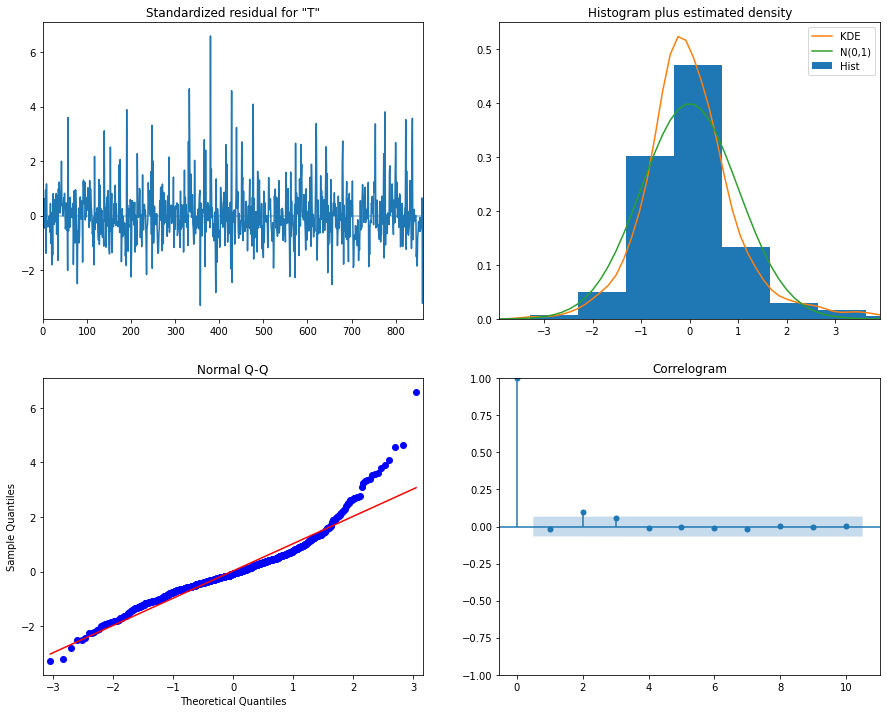

In [227]:

results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [229]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-15'), dynamic=False)
pred_ci = pred.conf_int()

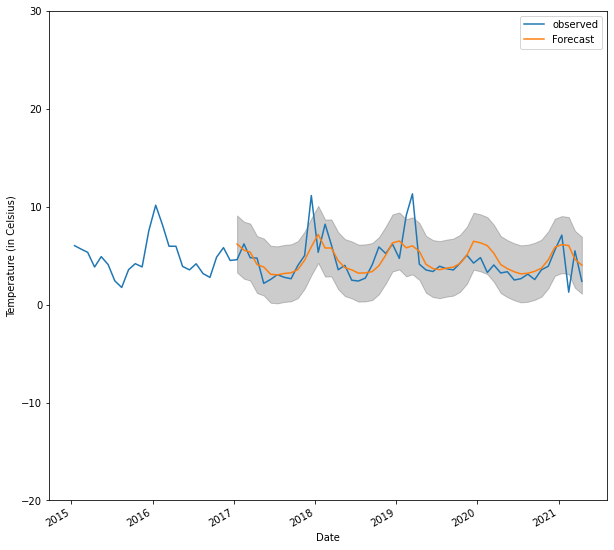

In [230]:

ax = one_step_df.T_mu_actual['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

In [232]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.T_mu_actual['2017-01-15':]
print(y_forecasted.shape)
print(y_truth.shape)
# Compute the mean square error
mse = MSE(y_truth, y_forecasted, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

(52,)
(52,)
The Mean Squared Error of our forecasts is 2.74


In [234]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-01-15'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

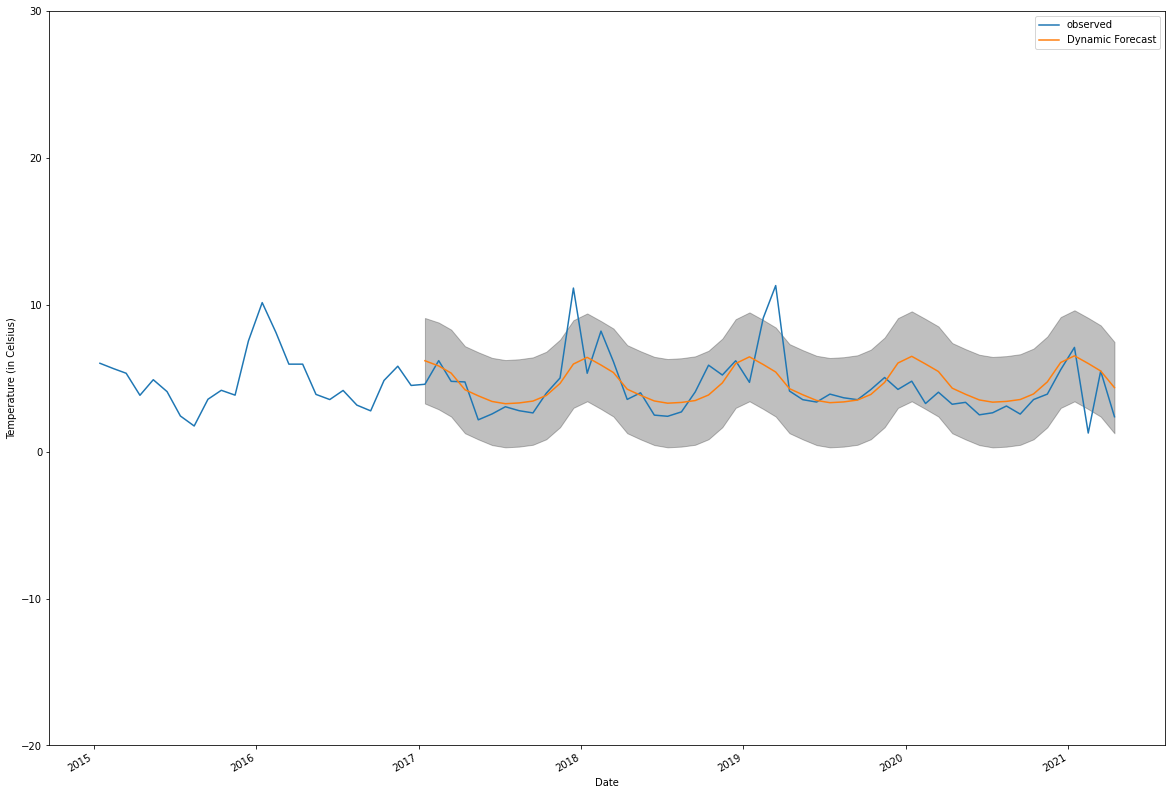

In [235]:
ax = one_step_df.T_mu_actual['2015':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

For temp MIN:

In [272]:
predicted_df = df2["timeMin"].to_frame().shift(1).rename(columns = {"timeMin": "Minpredicted" })
actual_df = df2["timeMin"].to_frame().rename(columns = {"timeMin": "Minactual" })

# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(10)

,Minactual,Minpredicted
time,,
1947-02-15,-3.48,-6.66
1947-03-15,-3.64,-3.48
1947-04-15,-1.90,-3.64
1947-05-15,-2.55,-1.90
1947-06-15,-1.95,-2.55
1947-07-15,-1.55,-1.95
1947-08-15,-2.24,-1.55
1947-09-15,-1.47,-2.24
1947-10-15,-0.43,-1.47


In [273]:
# Calculate the RMSE
temp_pred_err = MSE(one_step_df.Minactual, one_step_df.Minpredicted, squared=False)
print("The RMSE is",temp_pred_err)

The RMSE is 1.9519756


In [274]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [276]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.Minactual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4239.627033879555
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3818.617150539454
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3625.836640909553
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3121.3022018829615
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3504.22412758277
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3139.2320891202835
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3425.4787648328866
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3131.5357783334885
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3897.7072466664927
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3664.563140170385
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3623.8745407501774
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3115.78662236354
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3489.9374814799903
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3135.0125572302295
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3424.964837635054
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3125.1389331241776
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3713.412712447214
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:366

In [277]:
import statsmodels.api as sm

# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df.Minactual,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

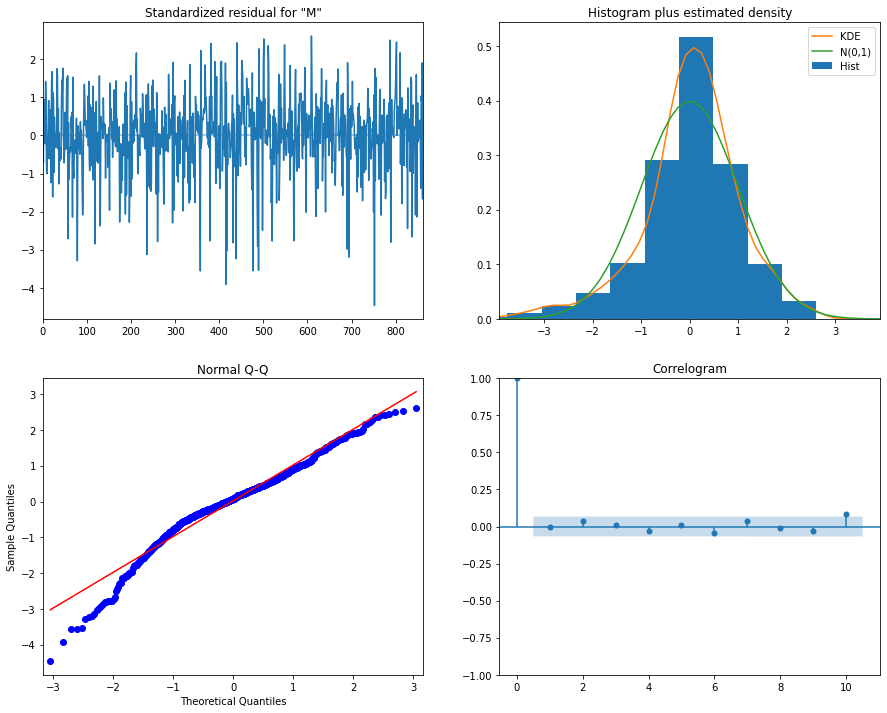

In [278]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [279]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-15'), dynamic=False)
pred_ci = pred.conf_int()

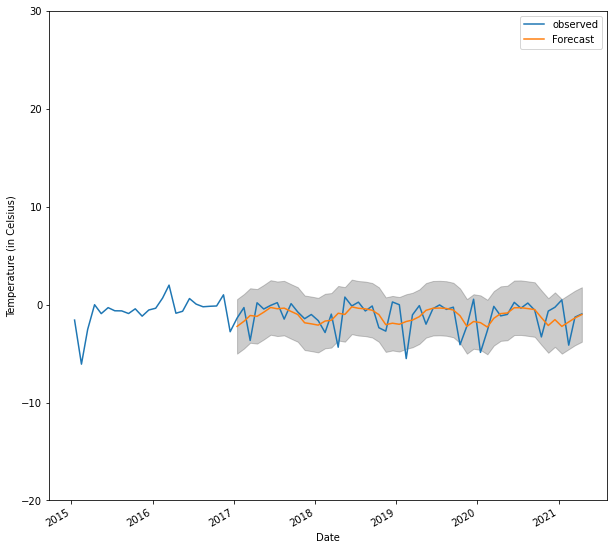

In [281]:
ax = one_step_df.Minactual['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

In [282]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.Minactual['2017-01-15':]
print(y_forecasted.shape)
print(y_truth.shape)
# Compute the mean square error
mse = MSE(y_truth, y_forecasted, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

(52,)
(52,)
The Mean Squared Error of our forecasts is 2.07


In [283]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-01-15'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

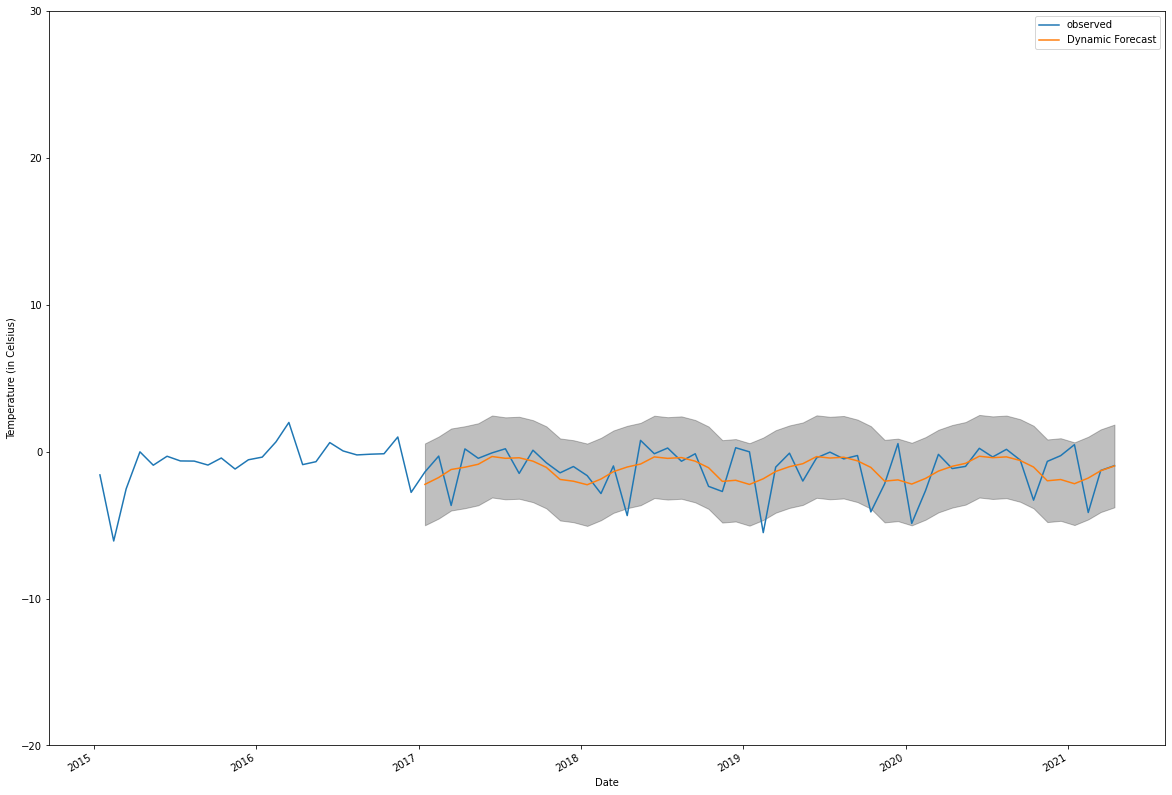

In [284]:
ax = one_step_df.Minactual['2015':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()